# Supplement 3: Hierarchical Clustering Model

Source code for prediction of COVID-19 test results. This is supplemental material to publication

Wojtusiak J, Bagais W, Vang J, Guralnik E, Roess A, Alemi F, "The Role of Symptom Clusters in Triage of COVID-19 Patients," Quality Management in Health Care, 2022.

Source code by Wejdan Bagais and Jee Vang with contribution of other authors. 

In [1]:
# import libraries
from models import select_attributes
from models import cut_hierarchy_columns

import pandas as pd
import numpy as np
import timeit
import pickle

import matplotlib as mpl
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import fcluster

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
from joblib import Parallel, delayed


import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

## LASSO Model for the 30 splits

In [ ]:
start = timeit.default_timer()

# list of values for inverse of regularization strength
c_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,2]

split_ids = []
cluster_n = []
cs = []
source = []
AUCs = []
prec = []
rec =  []
vars_cnt = []
vars_lists = []
ys_test = []
ys_pred = []

for i in range (0,30): 
    # read one of the 30 split data
    tr_path = "../data/30_splits_data/binary-transformed_tr_"+str(i)+".csv"
    ts_path = "../data/30_splits_data/binary-transformed_ts_"+str(i)+".csv"
     
    train = pd.read_csv(tr_path)
    test = pd.read_csv(ts_path)
    
    # Select the list of original predictors
    symptoms = train.columns.tolist()
    symptoms.remove('TestPositive')
    
    # For each cutoff point run tehe lasso model
    for cc in range(2,len(symptoms)):
        
        # create the hierarchical clusters based on the selected cutoff point
        XT, Xt, yT, yt = cut_hierarchy_columns(train, test, cc)
        
        # build the model for each value fo the inverse of regularization strength
        for c in c_list:
            auc, recall, precision, valid_cols, y_test, y_pred = select_attributes(XT, yT, Xt, yt, c)
            
            # add results to the list
            split_ids.append(i)
            cluster_n.append(cc)
            cs.append(c)
            source.append('cut_hierarchy')
            AUCs.append(auc)
            prec.append(precision)
            rec.append(recall)
            vars_cnt.append(len(valid_cols))
            vars_lists.append(valid_cols)
            if(y_test is not np.nan):
                ys_test.append(yt.values.tolist())
                ys_pred.append(y_pred.tolist())
            else:
                ys_test.append(np.nan)
                ys_pred.append(np.nan)
                

            print(f'ID {i}, number of clusters={cc:02}, C={c:.2f}, AUC={auc:.5f}, Precision={precision:.5f}, Recall={recall:.5f}, cls# {len(valid_cols)}') 

        
stop = timeit.default_timer()
print('Time: ', stop - start) 

In [ ]:
# create dataframe for all results
ff = pd.DataFrame({'split_ids'    : split_ids,
                   'cluster_n'    : cluster_n,
                   'cs'           : cs,
                   'source'       : source,
                   'AUCs'         : AUCs,
                   'prec'         : prec,
                   'rec'          : rec,
                   'vars_cnt'     : vars_cnt,
                   'vars_lists'   : vars_lists,
                   'y_test'       : ys_test,
                   'y_pred'       : ys_pred
                  })

In [17]:
# identify the list of unique selected predictors
unq_var = ff['vars_lists'].values.tolist()
for i in range(0, len(unq_var)):
    unq_var[i] = [sub.replace(':', ',') for sub in unq_var[i]]
    
sympt_lists = []
for i in range(0, len(unq_var)):
    l = ",".join(unq_var[i])
    l2 = list(set(l.split(',')))
    sympt_lists.append(l2)

In [ ]:
# Add the list of unique predictors and its count to the dataframe
ff['sympt_lists'] = sympt_lists
ff['sympt_cnt'] = ff['sympt_lists'].apply(lambda x :len(x))

In [19]:
# save the results
ff.to_csv('../data/results/hierarchical_model.csv', index=False)

## Identifying the best Cutoff point & inverse of regularization strength value (C)

In [20]:
table = pd.pivot_table(ff, values=['AUCs', 'vars_cnt', 'sympt_cnt']
                       , index=['cluster_n', 'cs']
                       , aggfunc=np.mean).round(decimals=4)


table['sympt_cnt'] = table['sympt_cnt'].round().astype(int)
table['vars_cnt'] = table['vars_cnt'].round().astype(int)

In [21]:
pd.set_option('display.max_rows', None)
table

AUCs  sympt_cnt  vars_cnt
cluster_n cs                              
2         0.1  0.5385          1         0
          0.2  0.5468          1         0
          0.3  0.5482          1         1
          0.4  0.5331          1         1
          0.5  0.5289          1         1
          0.6  0.5291          1         1
          0.7  0.5291          1         1
          0.8  0.5305          1         1
          0.9  0.5316          1         1
          1.0  0.5305          1         1
          1.5  0.5308          2         2
          2.0  0.5282          2         2
3         0.1  0.5730          1         1
          0.2  0.6236          2         2
          0.3  0.6204          2         2
          0.4  0.6185          2         2
          0.5  0.6233          2         2
          0.6  0.6251          3         3
          0.7  0.6245          3         3
          0.8  0.6256          3         3
          0.9  0.6275          3         3
          1.0  0.6294          3         3
          1.5  0.6336          3         3
          2.0  0.6365          3         3
4         0.1  0.6517          1         1
          0.2  0.7060          2         2
          0.3  0.7167          3         3
          0.4  0.7169          4         4
          0.5  0.7188          4         4
          0.6  0.7220          4         4
          0.7  0.7224          4         4
          0.8  0.7244          4         4
          0.9  0.7249          4         4
          1.0  0.7246          4         4
          1.5  0.7240          5         5
          2.0  0.7247          5         5
5         0.1  0.7298          2         2
          0.2  0.7585          3         3
          0.3  0.7612          3         3
          0.4  0.7620          4         4
          0.5  0.7655          4         4
          0.6  0.7674          4         4
          0.7  0.7659          4         4
          0.8  0.7663          5         5
          0.9  0.7648          5         5
          1.0  0.7643          5         5
          1.5  0.7611          5         5
          2.0  0.7611          5         5
6         0.1  0.7287          2         2
          0.2  0.7557          4         4
          0.3  0.7601          4         4
          0.4  0.7636          5         5
          0.5  0.7655          5         5
          0.6  0.7665          5         5
          0.7  0.7649          6         6
          0.8  0.7648          6         6
          0.9  0.7651          6         6
          1.0  0.7649          6         6
          1.5  0.7622          6         6
          2.0  0.7616          6         6
7         0.1  0.7284          2         2
          0.2  0.7491          4         4
          0.3  0.7569          5         5
          0.4  0.7603          6         6
          0.5  0.7616          6         6
          0.6  0.7639          6         6
          0.7  0.7632          6         6
          0.8  0.7644          6         6
          0.9  0.7657          7         7
          1.0  0.7658          7         7
          1.5  0.7665          7         7
          2.0  0.7659          7         7
8         0.1  0.7321          2         2
          0.2  0.7499          5         5
          0.3  0.7587          6         6
          0.4  0.7607          6         6
          0.5  0.7627          7         7
          0.6  0.7634          7         7
          0.7  0.7652          7         7
          0.8  0.7670          7         7
          0.9  0.7684          7         7
          1.0  0.7681          7         7
          1.5  0.7700          8         8
          2.0  0.7705          8         8
9         0.1  0.7355          2         2
          0.2  0.7513          5         5
          0.3  0.7636          7         7
          0.4  0.7664          7         7
          0.5  0.7680          8         8
          0.6  0.7687          8         8
          0.7  0.7701          8         8
          0.8  0.7

In [22]:
column = table["AUCs"]
column.idxmax()

(15, 0.6)

In [23]:
table.loc[column.idxmax()]

AUCs          0.7898
sympt_cnt    11.0000
vars_cnt     11.0000
Name: (15, 0.6), dtype: float64

### Selected number of clusters and C value

In [24]:
n_cluster = column.idxmax()[0]
_C =column.idxmax()[1]
n_cluster, _C

(15, 0.6)

### Read all data

In [2]:
# read data
path = "../data/preprocessed.csv"
df   = pd.read_csv(path)
df.columns  = [s.replace('_',' ') for s in df.columns]

### Dendrograms

In [3]:
metric = "cityblock" 
method = "complete"

### Clusters for the positive cases

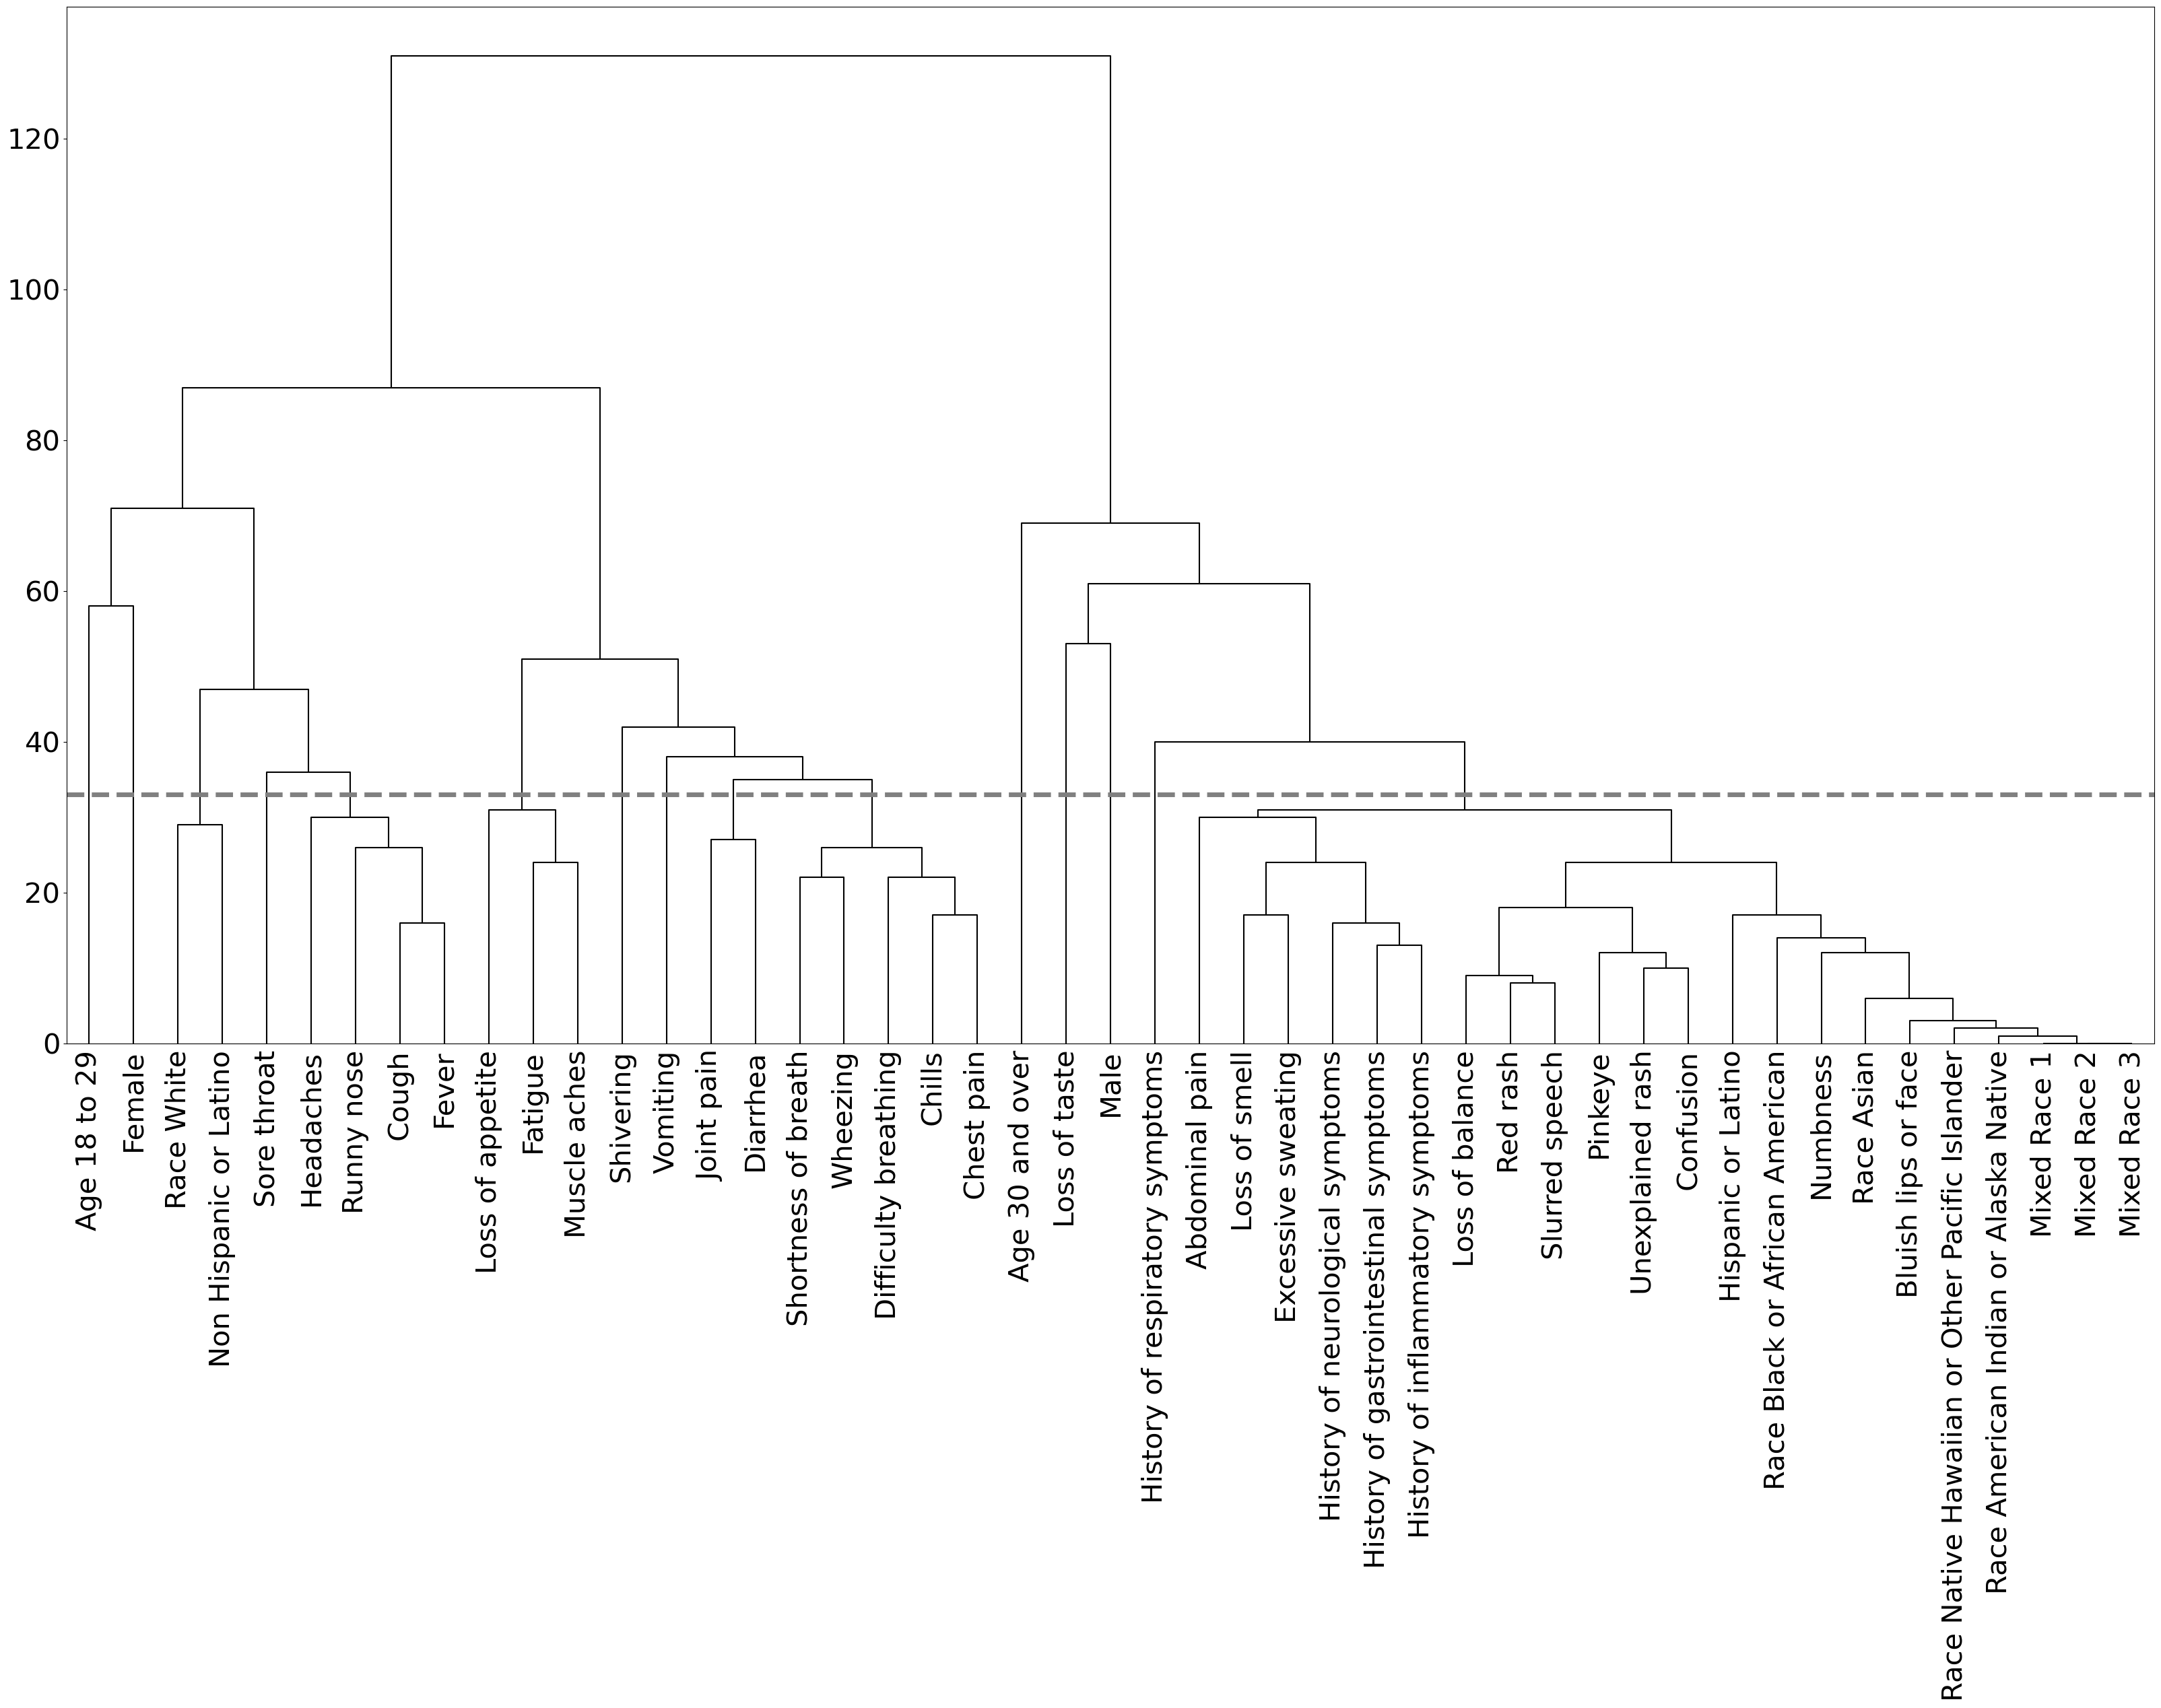

In [4]:
data = df[df['TestPositive'] == 1]
data = data.drop(columns=['TestPositive'])


plt.figure(figsize=(40, 20))
shc.set_link_color_palette(['black'])
dend3 = shc.dendrogram(shc.linkage(data.T, method=method, metric=metric), color_threshold=6500,
                           leaf_font_size=30, labels=data.T.index, count_sort=True, leaf_rotation=90)

plt.axhline(y=33, c='grey', lw=5, linestyle='dashed')
plt.yticks(fontsize=30)

plt.show()

### Clusters for the negative cases

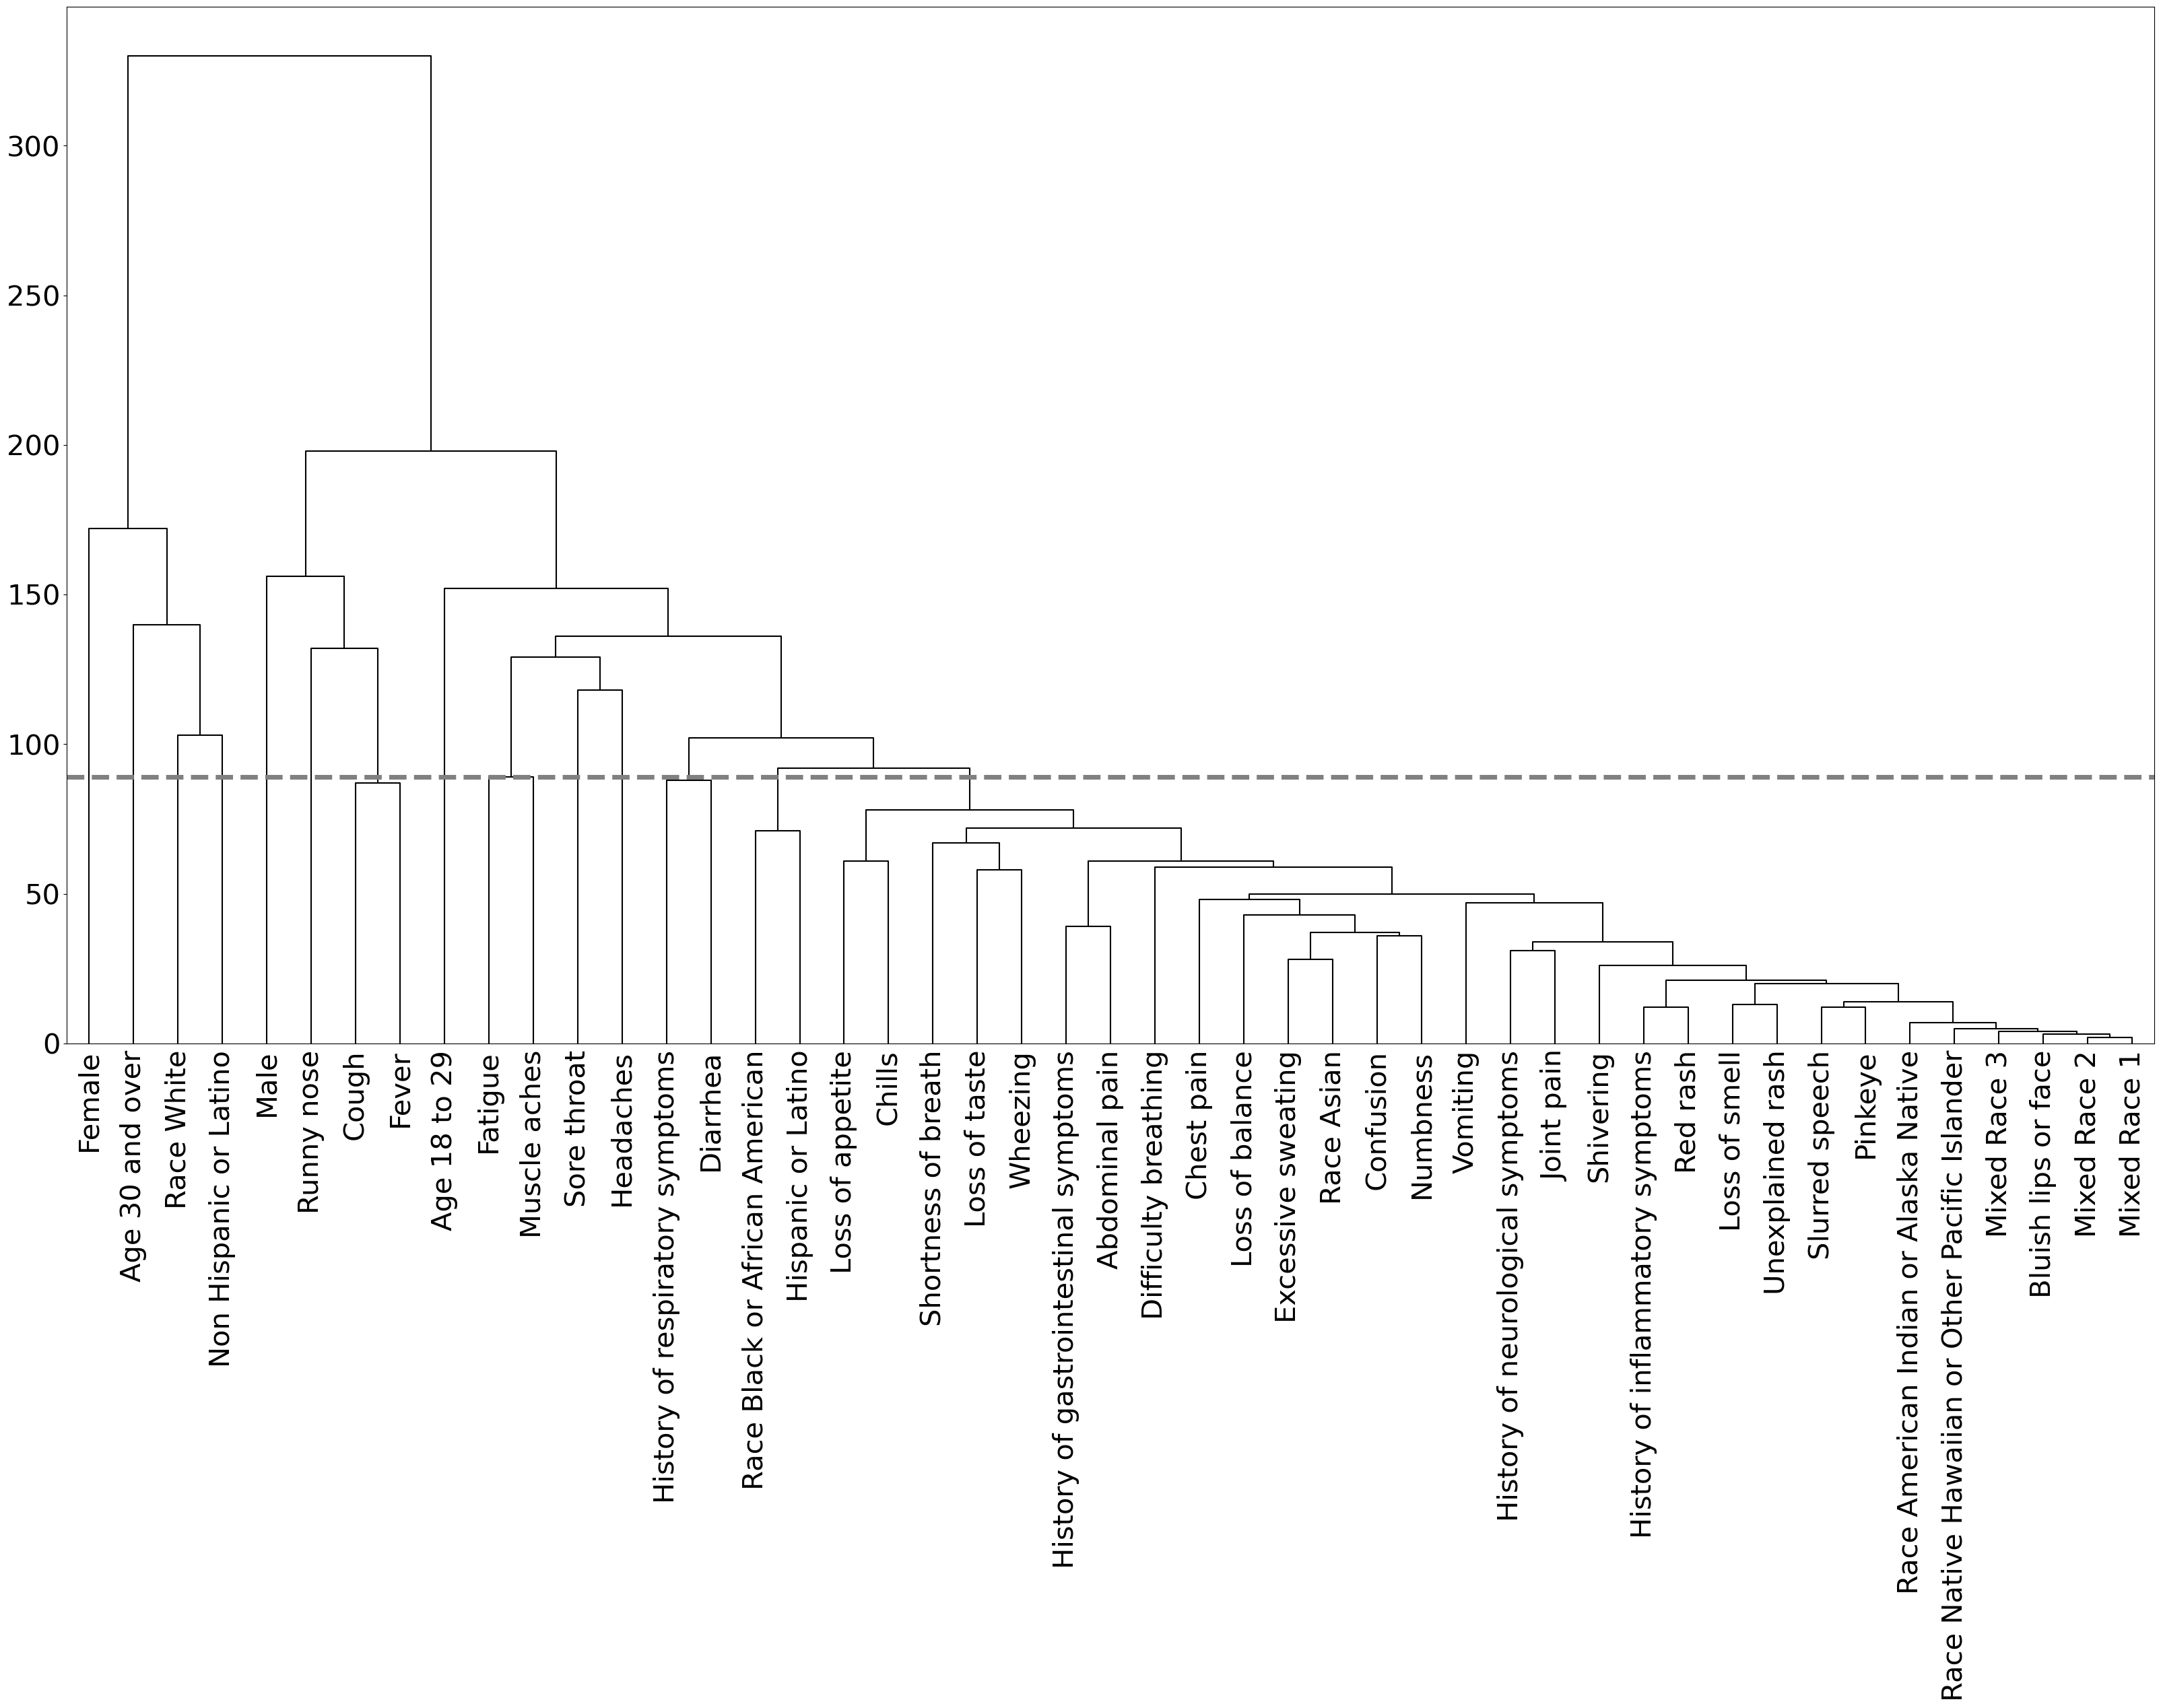

In [5]:
data = df[df['TestPositive'] == 0]
data = data.drop(columns=['TestPositive'])

plt.figure(figsize=(40, 20))
shc.set_link_color_palette(['black'])
dend3 = shc.dendrogram(shc.linkage(data.T, method=method, metric=metric),  color_threshold=15400,
                           leaf_font_size=30, labels=data.T.index, count_sort=True, leaf_rotation=90)

plt.axhline(y=89, c='grey', lw=5, linestyle='dashed')

shc.set_link_color_palette(None)  # reset to default after use
plt.yticks(fontsize=30)
plt.show()

## Building the model using all data to identify the list of predictors

### Creating clusters columns
- The purpose of the model is to identify the list of predictors. Since we already measured the performance in the previous step, we will train the model using all the data.

In [13]:
X, Xt, y, yt = cut_hierarchy_columns(df, df, n_cluster)

### k-fold cross-validation, k=24

In [14]:
Xy_pickle = 'BinaryDataX_hierarchical.p'
pickle.dump({'X': X, 'y': y}, open(Xy_pickle, 'wb'))

In [15]:
def do_validation(fold, tr, te, c= _C):
    data = pickle.load(open(Xy_pickle, 'rb'))
    X, y = data['X'], data['y']
    
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr].values.ravel(), y.iloc[te].values.ravel()
    
    print(f'fold {fold:02}')
        
    regressor = LogisticRegression(penalty='l1', solver='saga', C=c, n_jobs=-1, max_iter=5000*2)
    regressor.fit(X_tr, y_tr)
    
    y_pr = regressor.predict_proba(X_te)[:,1]
    
    score = roc_auc_score(y_te, y_pr)
    print(f'fold {fold:02}, score={score:.5f}')
    return score, regressor.coef_[0]
    

skf = StratifiedKFold(n_splits=24, shuffle=True, random_state=37)

In [16]:
outputs = Parallel(n_jobs=-1)(delayed(do_validation)(fold, tr, te, _C) 
                              for fold, (tr, te) in enumerate(skf.split(X, y)))

In [17]:
scores = pd.Series([score for score, _ in outputs])
coefs = pd.DataFrame([coef for _, coef in outputs], columns=X.columns)

## Coefficients from k-fold cross-validation that is consistent 95% of the time
- Consistent means in same direction and not absent.

In [18]:
def get_profile(df, col):
    s = df[col]
    
    s_pos = s[s > 0]
    s_neg = s[s < 0]
    
    n = df.shape[0]
    p_pos = len(s_pos) / n
    p_neg = len(s_neg) / n
    
    return {
        'field': col,
        'n_pos': len(s_pos),
        'n_neg': len(s_neg),
        'pct_pos': p_pos, 
        'pct_neg': p_neg, 
        'is_valid': 1 if p_pos >= 0.95 or p_neg >= 0.95 else 0
    }

In [19]:
valid_coefs = pd.DataFrame([get_profile(coefs, c) for c in coefs.columns]).sort_values(['is_valid'], ascending=False)
valid_coefs = valid_coefs[valid_coefs.is_valid == 1]

In [20]:
valid_cols = list(valid_coefs.field)
regressor = LogisticRegression(penalty='l1', solver='saga', C= _C, n_jobs=-1, 
                               max_iter=5000*2, random_state=37)
regressor.fit(X[valid_cols], y.values.ravel())

LogisticRegression(C=0.6, max_iter=10000, n_jobs=-1, penalty='l1',
                   random_state=37, solver='saga')

In [21]:
y_pred = regressor.predict_proba(X[valid_cols])[:,1]

t = X[valid_cols].copy()
t['y_pred'] = y_pred
t['y_actual'] = y
t.to_csv("../data/results/prediction_hierarchical_model.csv", index=False)

### Visualize coefficients

In [22]:
c = pd.Series(regressor.coef_[0], valid_cols)

In [23]:
plt.style.use('ggplot')

i = pd.Series([regressor.intercept_[0]], index=['intercept'])
s = pd.concat([c[c > 0], c[c < 0]]).sort_index()
s = pd.concat([i, s])
color = ['r' if v > 0 else 'b' for v in s]

ax = s.plot(kind='bar', color=color, figsize=(20, 4))
_ = ax.set_title(f'Logistic Regression, validated auc={scores.mean():.5f}')

In [24]:
s_odds = np.exp(s)
color = ['r' if v > 1 else 'b' for v in s_odds]

ax = s_odds.plot(kind='bar', color=color, figsize=(20, 4))
_ = ax.set_title(f'Logistic Regression, coefficient odds')

### Tabular output of coefficients with odds

In [25]:
pd.DataFrame({
    'coefficient': s,
    'coefficient_odds': s_odds
}).round(decimals=2)

coefficient  \
intercept                                                 -2.03   
Age 30 and over                                           -0.55   
Cough & Fever & Headaches & Runny nose                     1.57   
Female                                                     0.33   
Headaches                                                  0.61   
History of respiratory symptoms                            0.24   
Loss of taste                                              0.77   
Muscle aches                                               0.22   
Race White                                                 0.38   
Runny nose                                                -0.55   
Shortness of breath & Wheezing & Chills & Chest...         2.22   

                                                    coefficient_odds  
intercept                                                       0.13  
Age 30 and over                                                 0.58  
Cough & Fever & Headaches & Runny nose                          4.81  
Female                                                          1.39  
Headaches                                                       1.85  
History of respiratory symptoms                                 1.27  
Loss of taste                                                   2.15  
Muscle aches                                                    1.25  
Race White                                                      1.46  
Runny nose                                                      0.57  
Shortness of breath & Wheezing & Chills & Chest...              9.18

In [26]:
(pd.DataFrame({
    'coefficient': s,
    'coefficient_odds': s_odds
}).round(decimals=4)).shape

(11, 2)